# Análisis de la depresión y la ansiedad en el aborto en Twitter

In [1]:
# Adding libraries

# Data operations
import json
import missingno as msno


import csv
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np

# Text cleaning
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Date/time handling
from datetime import datetime
import time

# Sentiment Analysis
from nltk.sentiment import SentimentIntensityAnalyzer
#import nltk
#nltk.download('vader_lexicon') # To perform sentiment analysis
from textblob import TextBlob

# Topic extraction
import gensim
from gensim import corpora, models
from gensim.matutils import jaccard
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models

#from pyLDAvis import gensim
#pyLDAvis.enable_notebook()

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

/home/olivier/.cache/pypoetry/virtualenvs/miscarriagetwitteranalysis--XHisNvx-py3.8/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


## 1. Extracción de datos
De la aplicación creada de Twitter Developer obtenemos las siguientes claves de acceso, que nos permitirán acceder a la API de Twitter para obtener los tweets:

## 2. Preparación de los datos

In [2]:
# Orignal files paths
path_json = 'dataCollection/tweets.json'

In [3]:
tweets = list()
n = 0
max_row = 10000000
with open(path_json, 'r') as f:
    for l in f:
        tweets.append(json.loads(l))
        n+=1
        if n == max_row:
            break
        
# Read JSON into Pandas dataframe
df = pd.DataFrame(tweets)

In [4]:
def flat_dict_col(df, col):
    df2 = pd.json_normalize(df[col])
    df2.columns = ['{}.{}'.format(col, i) for i in df2.columns]
    df = df.join(df2)
    del df[col]
    return df

In [5]:
df = flat_dict_col(df, 'author')
df = flat_dict_col(df, 'public_metrics')
df = flat_dict_col(df, 'geo')
#df = flat_dict_col(df, 'referenced_tweets')

del df['_id']


# Transform into date time object
df['created_at'] = df['created_at'].astype('datetime64[ns]') 


### 2.2. Transformación

Ahora ya hemos seleccionado las columnas que necesitaremos para el análisis posterior, pero debemos realizar transformaciones a las columnas para facilitar su uso. Las transformaciones que realizaremos son:

* Filtrado de tweets que no estén en inglés
* Transformación del formato de las columnas de fecha (creación de las columnas "year", "month", "day", "hour" y "day_of_week" para el análisis temporal)
* Creación de una columna que indique si el tweet es una respuesta de otro tweet
* Creación de una columna indicando si el tweet contiene contenido multimedia (photo, video o gif)

In [6]:
# Mentioned tranformations
# Filtering out tweets not in English
def filter_English_tweets(df):
    df = df[df['lang'] == 'en']
    return df

# Getting if the tweet is a reply or not
def is_reply(df):
    df['is_reply'] =  df['in_reply_to_user_id'].apply(lambda x: False if np.isnan(x) else True)

    return df

# Extracting if tweet contains photo, video or gif (or none)
def media_extraction(df):
    clean_entities = df['extended_tweet_entities_media'].fillna(value="").astype(str)
    df['extended_tweet_entities_media'] = clean_entities
                        
    df['has_photos'] = df['extended_tweet_entities_media'].str.contains("'type': 'photo'")
    df['has_videos'] = df['extended_tweet_entities_media'].str.contains("'type': 'video'")
    df['has_gifs'] = df['extended_tweet_entities_media'].str.contains("'type': 'animated_gif'")

    return df


In [7]:
# Function to apply all transformations
def apply_transformations(df):

    df = filter_English_tweets(df) # Get only tweets in English
    #df = dates_transformation(df) # Create date columns
    #df = is_reply(df) # Create is_reply column
    #df = media_extraction(df) # Extract if we have media
    #df = remove_extra_spaces(df) # Removing messy spaces from texts

    return df

In [8]:
# Apply all transformation to dataframes
df = apply_transformations(df)
df.head()

,id,author_id,conversation_id,created_at,edit_history_tweet_ids,in_reply_to_user,in_reply_to_user_id,lang,referenced_tweets,text,...,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count,geo.place_id,geo.country,geo.full_name,geo.id,geo.coordinates.type,geo.coordinates.coordinates
0,1575636275432161280,1518987195465359363,1575319565168418817,2022-09-29 23:58:56,[1575636275432161280],{},1268223690480615424,en,"[{'type': 'replied_to', 'id': '157531956516841...",@NoLieWithBTC Some people consider abortion to...,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1575636257409236992,1504188003601641473,1575544520011239424,2022-09-29 23:58:52,[1575636257409236992],{},1480091258395803655,en,"[{'type': 'replied_to', 'id': '157554452001123...",@TheVikingDane “TW have periods”\n“Men can get...,...,0,0,4,0,NaN,NaN,NaN,NaN,NaN,NaN
2,1575636237351673856,728021810508382209,1575485376323461120,2022-09-29 23:58:47,[1575636237351673856],{},361569788,en,"[{'type': 'replied_to', 'id': '157548537632346...",@Maggie_Hassan There is no nationwide abortion...,...,0,0,2,0,NaN,NaN,NaN,NaN,NaN,NaN
3,1575636225976737795,369796624,1574745661093847040,2022-09-29 23:58:44,[1575636225976737795],{},202038553,en,"[{'type': 'replied_to', 'id': '157563569044798...",@patriot_1776US @chiwhitesox326 @Arvolash_ @Dr...,...,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,1575636208687804416,1170475742,1575618291829133312,2022-09-29 23:58:40,[1575636208687804416],{},1149026282920914944,en,"[{'type': 'replied_to', 'id': '157563240888750...",@elevateconvo @Politics_Polls @foxnewspoll Fru...,...,0,1,5,0,NaN,NaN,NaN,NaN,NaN,NaN


/home/olivier/.cache/pypoetry/virtualenvs/miscarriagetwitteranalysis--XHisNvx-py3.8/lib/python3.8/site-packages/missingno/missingno.py:73: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax0.grid(b=False)
/home/olivier/.cache/pypoetry/virtualenvs/miscarriagetwitteranalysis--XHisNvx-py3.8/lib/python3.8/site-packages/missingno/missingno.py:142: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=False)


<AxesSubplot: >

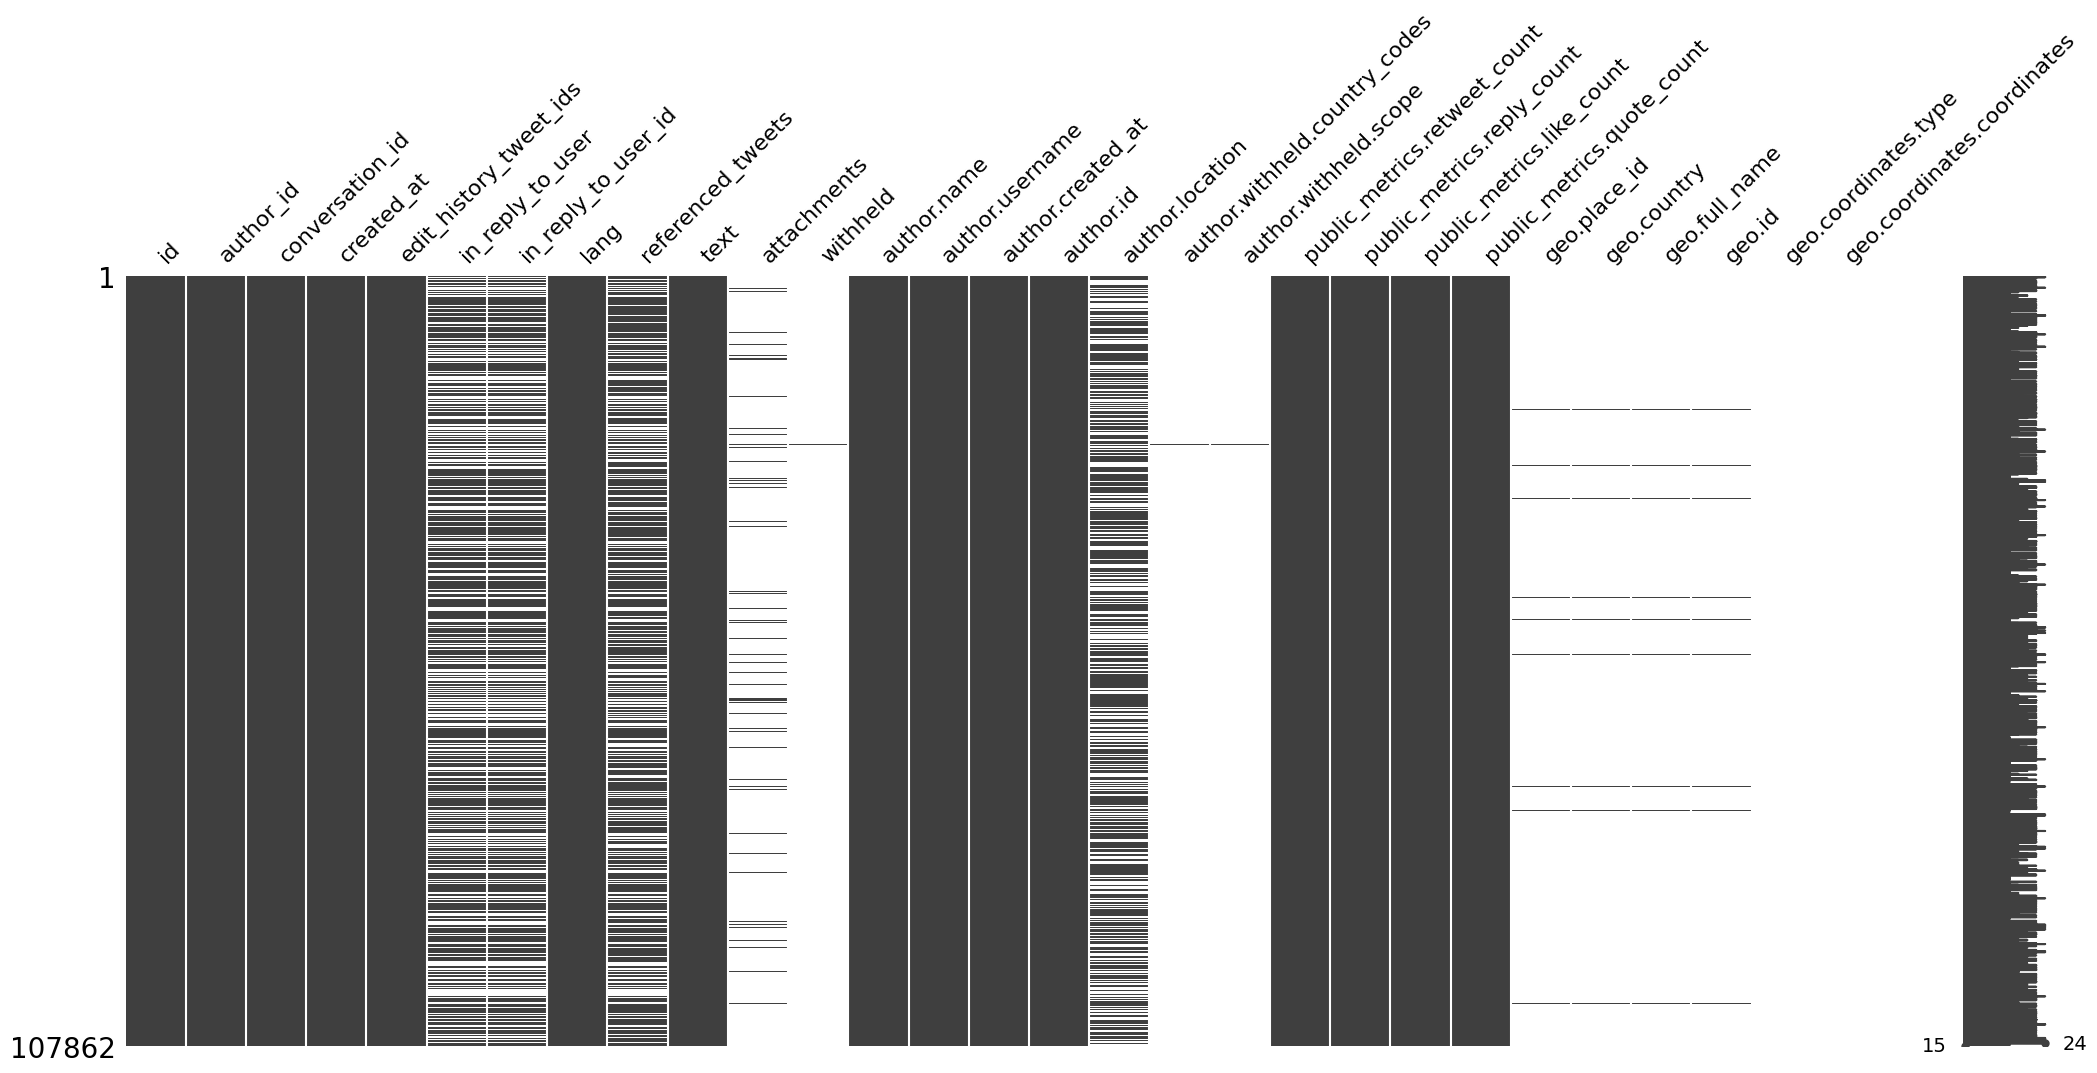

In [9]:
msno.matrix(df)

### 2.3. Limpieza del texto

A parte de las columnas transformadas anteriormente, tenemos que realizar un proceso de limpieza específico para la columna que contiene el texto del tweet.

En primer lugar, ya que los tweets contienen su texto en 2 campos diferentes dependiendo si están truncados o no, debemos crear un campo que use el texto normal o el extendido dependidiendo del tipo de tweet.

A continuación debemos aplicar las siguientes transformaciones para limpiar el texto de los tweets:
* Texto todo en minúscula
* Eliminación de usernames (@username)
* Eliminación de hashtags (#hashtag)
* Eliminación de hipervínculos (https...)
* Eliminación de dígitos
* Eliminación de signos de puntuación y espacios extra
* Eliminación de palabras de 1 carácter
* Tokenization
* Eliminación de stopwords
* Lemmatization

In [10]:
# Functions the mentioned text cleaning steps


# Removing extra spaces from all texts
def remove_extra_spaces(sentence):
    sentence = sentence.replace(r'\n',' ', regex=True) 
    sentence = sentence.replace(r'/\|/g',' ', regex=True) 
    return sentence


def lowercase_text(sentence):
    return sentence.lower()

def remove_usernames(sentence):
    sentence = re.sub(r'@\w+',' ', sentence)
    return sentence

def remove_hashtags(sentence):
    sentence = re.sub(r"#\w+",' ', sentence)
    return sentence

def remove_links(sentence):
    sentence = re.sub(r'\bhttps?://[^\s]*',' ', sentence)
    return sentence

def remove_numbers(sentence):
    sentence = re.sub(r'\d+',' ', sentence)
    return sentence

def remove_punctuation_and_spaces(sentence):
    sentence = re.sub(r'&amp;', ' ', sentence) # Specific for &amp;
    sentence = re.sub(r'[^\w\s]',' ', sentence)
    sentence = ' '.join(sentence.split())
    return sentence

def remove_1letter_words(sentence):
    sentence = re.sub(r'\b\w{1}\b', ' ', sentence)
    return sentence

def tokenize(sentence):
    list_of_words = sentence.split(" ")
    return list_of_words

def remove_stopwords(list_of_words):
    # Getting English stopwords
    stop_words = set(stopwords.words('english'))

    filtered_words = []
    for word in list_of_words: 
        if word not in stop_words: 
            filtered_words.append(word) 

    return filtered_words

def lemmatize(list_of_words):
    # Getting English lemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    
    lemma_words = []
    for w in list_of_words:
        word1 = wordnet_lemmatizer.lemmatize(w, pos = "n") # Names
        word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v") # Verbs
        word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a") # Adjectives
        lemma_words.append(word3)

    return lemma_words

In [11]:
# Function to apply all text tranformations
def text_cleaning(df):
    '''
    Given a pandas dataframe with tweets returns a list of clean tweet texts
    @input: pandas dataframe with tweets
    @output: list of clean tweets (same order as in df)
    '''
    lists_of_text = []

    for text in df['text']:
        sentence = str(text)

        # Text transformations
        sentence = lowercase_text(sentence) # All in lowercase
       # sentence = remove_extra_spaces(sentence)

        sentence = remove_links(sentence) # Remove links
        sentence = remove_hashtags(sentence) # Remove Hashtags
        sentence = remove_usernames(sentence) # Remove usernames
        sentence = remove_numbers(sentence) # Remove numbers
        sentence = remove_punctuation_and_spaces(sentence) # Remove punctuation signs and multiple spaces
        sentence = remove_1letter_words(sentence) # Remove words with len=1
        sentence = remove_punctuation_and_spaces(sentence)
        
        list_of_words = tokenize(sentence) # Tokenization
        list_of_words = remove_stopwords(list_of_words) # Remove stopwords
        list_of_words = lemmatize(list_of_words) # Lemmatization
        
        # Converting list of words to text again
        lists_of_text.append(' '.join(list_of_words))

    return lists_of_text

In [12]:
# Limpieza de textos
df['clean_text'] = text_cleaning(df)
df['clean_text'].head()

0    people consider abortion sin believe respect p...
1      tw period men get pregnant abortion woman issue
2                              nationwide abortion ban
3    promote state right federal intervention segre...
4    frustrate dems run social security medicare ab...
Name: clean_text, dtype: object

/home/olivier/.cache/pypoetry/virtualenvs/miscarriagetwitteranalysis--XHisNvx-py3.8/lib/python3.8/site-packages/missingno/missingno.py:73: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax0.grid(b=False)
/home/olivier/.cache/pypoetry/virtualenvs/miscarriagetwitteranalysis--XHisNvx-py3.8/lib/python3.8/site-packages/missingno/missingno.py:142: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=False)


<AxesSubplot: >

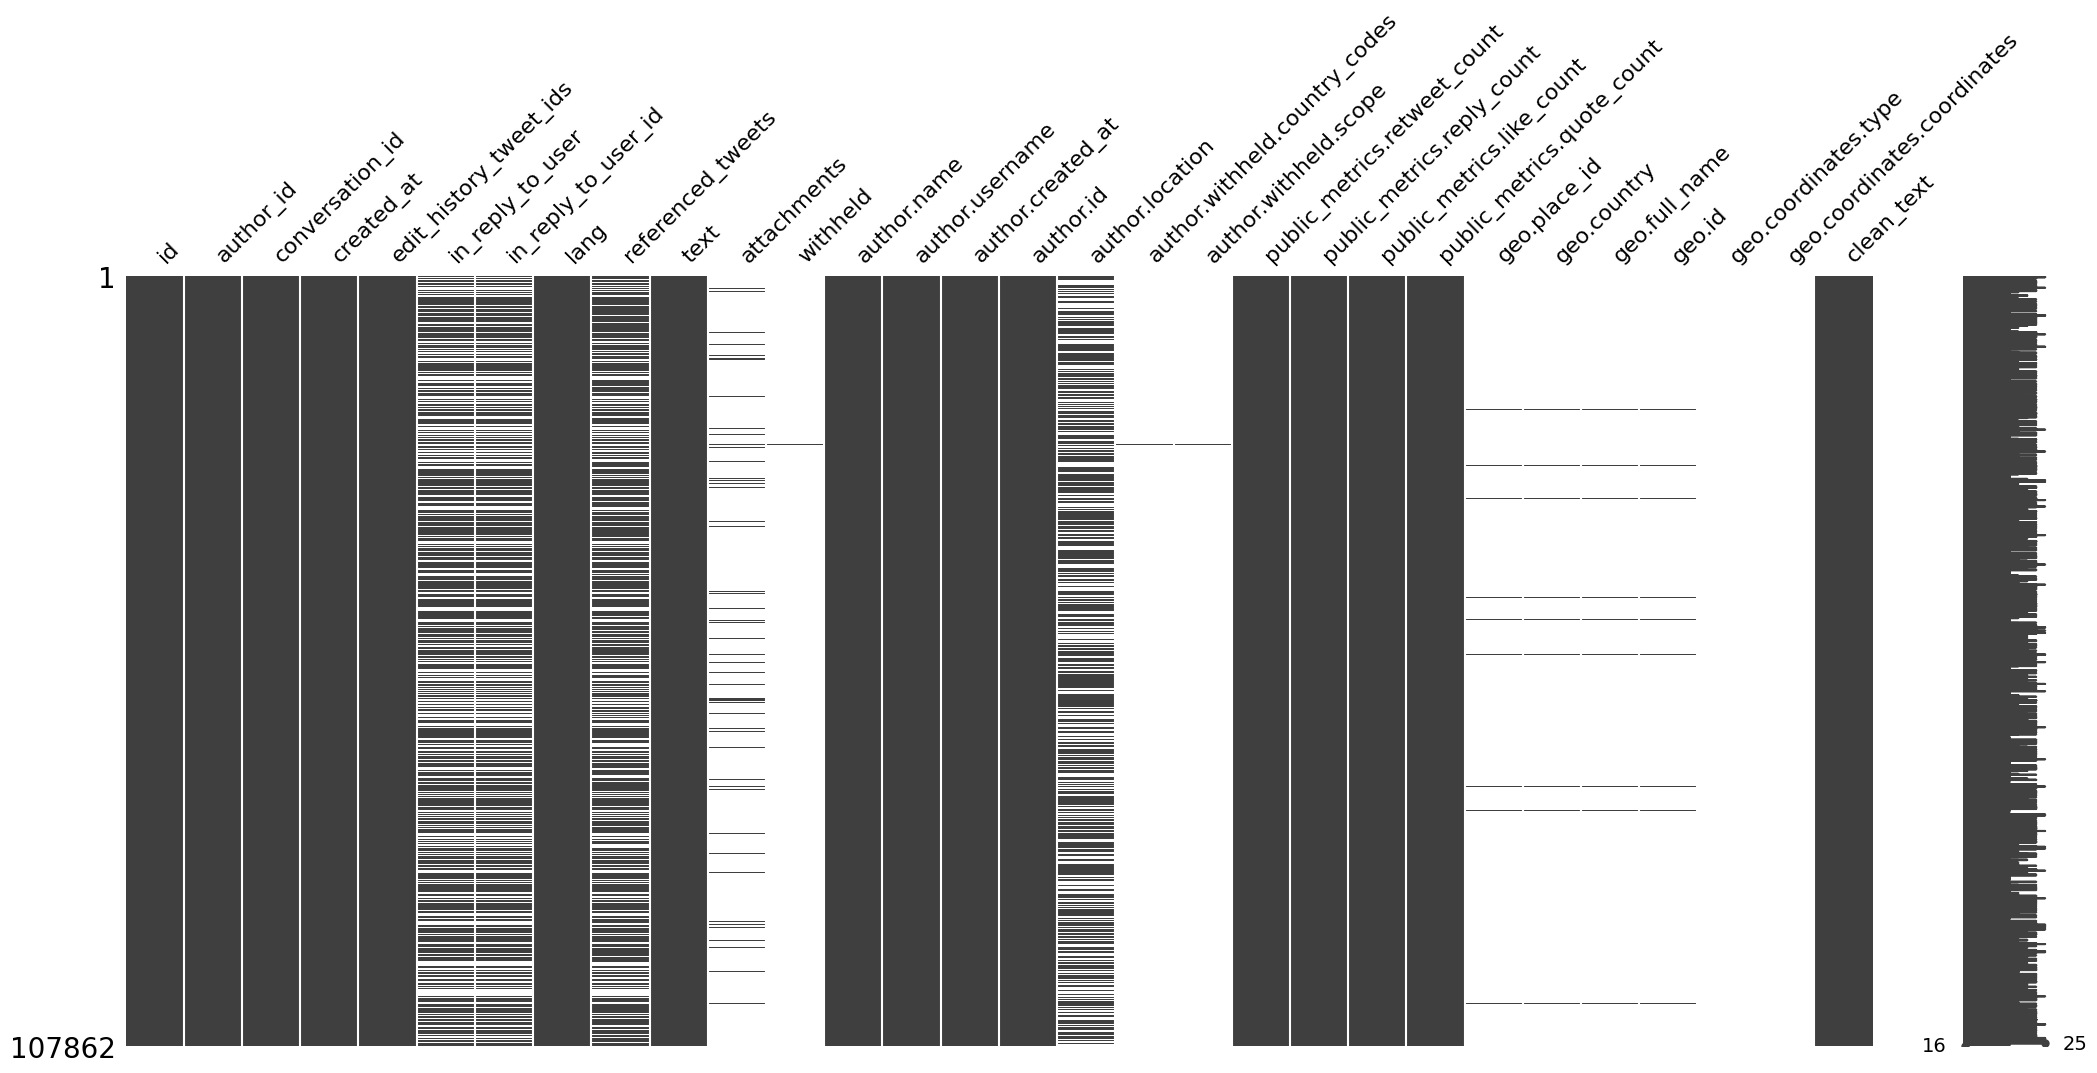

In [13]:
msno.matrix(df)

### 2.4. Filtrado de tweets no relacionados

Durante el análisis de los tweets hemos podido observar que algunos de ellos contienen las palabras específicadas en la búsqueda, pero que no tratan sobre el miscarriage como tal. A continuación se aplica un filtrado de tweets para intentar eliminar algunos de los que no tratan sobre el tema:

In [14]:
# FLAGGED WORDS (UNRELATED TWEETS)
flagged_words = [
    r'\bmiscarriage\s+of\s+justice\b',
    r'\bjustice\b',
    r'weight\s*loss']

In [15]:
# Functions to filter unrelated tweets
def filter_unrelated_tweets_flagged(df):
    # Filtering tweets with FLAGGED words
    for flagged_word in flagged_words:
        df = df[~df['clean_text'].str.contains(flagged_word, regex=True, flags=re.IGNORECASE)]

    return df    


In [16]:
# Filtering out unrelated tweets
print("Before filtering: ", len(df))

df = filter_unrelated_tweets_flagged(df)
print("After filtering: ", len(df))

Before filtering:  107862
After filtering:  106901


## 3. Exploración de datos

AxesSubplot(0.125,0.11;0.775x0.77)


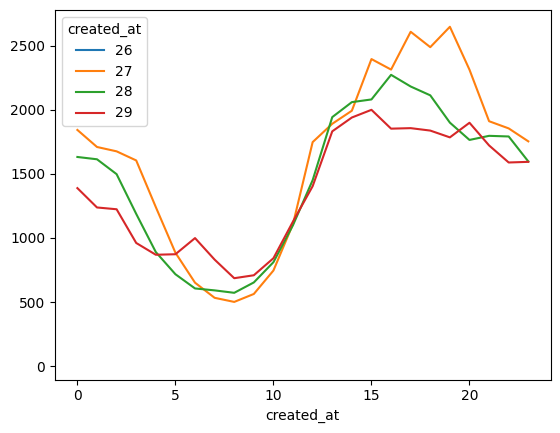

In [17]:

df1 = df.groupby([df['created_at'].dt.hour, df['created_at'].dt.day]).size().unstack().plot()

print (df1)


In [18]:
df.columns

Index(['id', 'author_id', 'conversation_id', 'created_at',
       'edit_history_tweet_ids', 'in_reply_to_user', 'in_reply_to_user_id',
       'lang', 'referenced_tweets', 'text', 'attachments', 'withheld',
       'author.name', 'author.username', 'author.created_at', 'author.id',
       'author.location', 'author.withheld.country_codes',
       'author.withheld.scope', 'public_metrics.retweet_count',
       'public_metrics.reply_count', 'public_metrics.like_count',
       'public_metrics.quote_count', 'geo.place_id', 'geo.country',
       'geo.full_name', 'geo.id', 'geo.coordinates.type',
       'geo.coordinates.coordinates', 'clean_text'],
      dtype='object')

In [19]:
# Tweet location
df.groupby('geo.country').size().sort_values(ascending=False)

geo.country
Estados Unidos            1173
India                       80
Reino Unido                 52
Canadá                      29
South Africa                25
Kenia                       13
Australia                   12
Namibia                     11
Ghana                        8
Nigeria                      7
Alemania                     6
Irlanda                      5
Uganda                       5
Italia                       4
Zimbabwe                     4
Francia                      3
México                       3
República de Filipinas       3
España                       2
ישראל                        2
Suecia                       2
Holanda                      2
Tailandia                    2
Sri Lanka                    1
Nueva Zelanda                1
Austria                      1
República de Ruanda          1
República Checa              1
Bahamas                      1
Trinidad y Tobago            1
Portugal                     1
Pakistán                   

In [20]:
df.columns

Index(['id', 'author_id', 'conversation_id', 'created_at',
       'edit_history_tweet_ids', 'in_reply_to_user', 'in_reply_to_user_id',
       'lang', 'referenced_tweets', 'text', 'attachments', 'withheld',
       'author.name', 'author.username', 'author.created_at', 'author.id',
       'author.location', 'author.withheld.country_codes',
       'author.withheld.scope', 'public_metrics.retweet_count',
       'public_metrics.reply_count', 'public_metrics.like_count',
       'public_metrics.quote_count', 'geo.place_id', 'geo.country',
       'geo.full_name', 'geo.id', 'geo.coordinates.type',
       'geo.coordinates.coordinates', 'clean_text'],
      dtype='object')

In [21]:
# Author locations
df.groupby('author.location').size().sort_values(ascending=False)

author.location
United States                     1774
USA                               1339
Washington, DC                     873
New Jersey                         792
Estados Unidos                     583
                                  ... 
Koto Tangah, Indonesia               1
Kottayam district,Kerala,India       1
Kozhikode                            1
Krakow                               1
🪸Mo'orea in the past/future          1
Length: 16366, dtype: int64

In [22]:
# Avg. number of words per tweet
df_text = df["clean_text"].map(lambda x: x.split(' '))
count_words = df_text.apply(lambda x: len(x))

print("Awareness: ", np.mean(count_words))

Awareness:  14.606074779468855


Text(0, 0.5, 'Media de palabras por tweet')

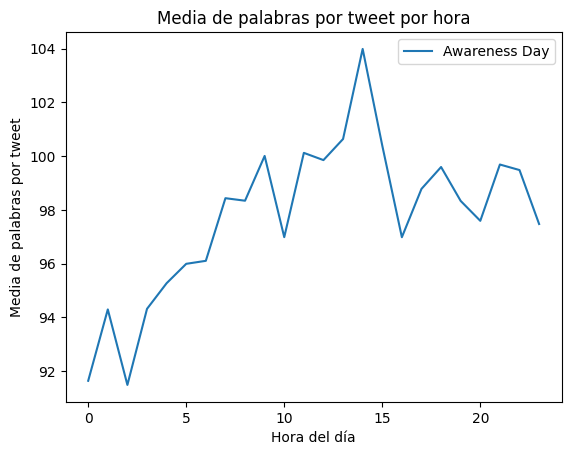

In [23]:
# Avg. number of words per tweet per hour
df['review_text'] = df["clean_text"].map(lambda x: x.split(' '))
df['count_words'] = df["clean_text"].apply(lambda x: len(x))
df_awareness_text_hour = df.groupby([df['created_at'].dt.hour, df['created_at'].dt.day])['count_words'].mean()
df_awareness_text_hour


plt.plot(df_awareness_text_hour)
plt.title("Media de palabras por tweet por hora")
plt.xlabel("Hora del día")
plt.ylabel("Media de palabras por tweet")

## 4. Modelado: Análisis de sentimiento y extracción de temas

### 4.1. Análisis de sentimiento

Usaremos la librería NLTK para el cálculo de la polaridad del tweet, y la librería TextBlob para el cálculo de la subjetividad, y guardaremos los resultados en nuevas columnas de los dataframes.


In [24]:
# NLTK function for Polarity
def sentiment_analysis_polarity_NLTK(df):
    '''
    Given a dataframe with tweets, it add 4 new columns to express sentiment polarity:
    negative score, positive score, neutral score and compound
    '''

    sia = SentimentIntensityAnalyzer()

    tweets = df['clean_text']

    negative_values = []
    neutral_values = []
    positive_values = []
    compound_values = []

    for tweet in tweets:
        polarity_dict = sia.polarity_scores(tweet)
        
        negative_values.append(polarity_dict['neg'])
        neutral_values.append(polarity_dict['neu'])
        positive_values.append(polarity_dict['pos'])
        compound_values.append(polarity_dict['compound'])

    df['polarity_negative'] = negative_values
    df['polarity_positive'] = positive_values
    df['polarity_neutral'] = neutral_values
    df['polarity_compound'] = compound_values
    
    return df

In [25]:
# TextBlob function for Subjectivity
def sentiment_analysis_TextBlob(df):
    tweets = df['clean_text']

    polarity_list = []
    subjectivity_list = []

    for tweet in tweets:
        sentiment = TextBlob(tweet).sentiment
        polarity = sentiment.polarity
        polarity_list.append(polarity)

        subjectivity = sentiment.subjectivity
        subjectivity_list.append(subjectivity)

    df['polarity'] = polarity_list
    df['subjectivity'] = subjectivity_list

    return df

In [26]:
# Getting polarity and subjectivity for all tweets
df = sentiment_analysis_polarity_NLTK(df)

df = sentiment_analysis_TextBlob(df)


### 4.2. Extracción de temas (LDA)

#### 4.2.1. Entrenamiento del modelo baseline

A continuación crearemos un diccionario (id2word) y una Bag Of Words para poder entrenar un modelo LDA. El número de temas y los otros hiperparámetros se seleccionaran aleatoriamente en este apartado, ya que en el siguiente realizaremos un hiperparameter tuning.

In [27]:
# Creating models changing number of topics
# Split words
df["review_text"] = df["clean_text"].map(lambda x: x.split(' '))

# Word dictionary
id2word = corpora.Dictionary(df['review_text'])

# Corpus
corpus = df['review_text']
#corpus = [id2word.doc2bow(df['review_text']) for text in texts]

# Bag of Words
bow = [id2word.doc2bow(tweet) for tweet in df['review_text']]

#### 4.2.2. Hyperparameter tuning

Hemos entrenado dos modelos LDA con un número de temas al azar y sin seleccionar los hiperparámetros. Para evaluar un modelo de LDA usamos la "Topic Coherence", que mide el grado de similaridad semántica entre las palabras con mayor peso dentro de un tema. 

Por lo tanto, los mejores parámetros para el modelo LDA deben maximizar la coherencia.

Adicionalmente, también buscaremos minimizar la repetición de palabras entre temas, y para medir exta repetición usaremos la similaridad de Jaccard, que mide la similitud entre dos conjuntos.

In [28]:
# Considering several topics
num_topics = list(range(4, 15))
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    
    LDA_models[i] =  models.LdaMulticore(corpus=bow, 
                                        id2word=id2word,
                                        num_topics=i)
    
    
    
    # Get topics to calculate Jaccard similarity
    returned_topics = LDA_models[i].show_topics(num_topics=i,num_words=num_keywords,formatted=False)
    print('done the {} topic'.format(i))
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in returned_topics]

done the 4 topic
done the 5 topic
done the 6 topic
done the 7 topic
done the 8 topic
done the 9 topic
done the 10 topic
done the 11 topic
done the 12 topic
done the 13 topic
done the 14 topic


In [29]:
## Save the models:
from gensim.test.utils import datapath

for m in LDA_models:
    print(LDA_models[m])
    temp_file = datapath("lda_model_{}".format(m))
    LDA_models[m].save(temp_file)

LdaMulticore<num_terms=30125, num_topics=4, decay=0.5, chunksize=2000>
LdaMulticore<num_terms=30125, num_topics=5, decay=0.5, chunksize=2000>
LdaMulticore<num_terms=30125, num_topics=6, decay=0.5, chunksize=2000>
LdaMulticore<num_terms=30125, num_topics=7, decay=0.5, chunksize=2000>
LdaMulticore<num_terms=30125, num_topics=8, decay=0.5, chunksize=2000>
LdaMulticore<num_terms=30125, num_topics=9, decay=0.5, chunksize=2000>
LdaMulticore<num_terms=30125, num_topics=10, decay=0.5, chunksize=2000>
LdaMulticore<num_terms=30125, num_topics=11, decay=0.5, chunksize=2000>
LdaMulticore<num_terms=30125, num_topics=12, decay=0.5, chunksize=2000>
LdaMulticore<num_terms=30125, num_topics=13, decay=0.5, chunksize=2000>
LdaMulticore<num_terms=30125, num_topics=14, decay=0.5, chunksize=2000>


In [30]:
# Calculating avg jaccard similarity between topics
LDA_distance = {}
for i in range(0, len(num_topics)-1):
    jaccard_similarities = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]):
        similarities = []
        #print(topic1)
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]):
            similarities.append(jaccard(topic1, topic2))    
        
        jaccard_similarities.append(similarities)    

    LDA_distance[num_topics[i]] = jaccard_similarities
                
mean_similarities = [np.array(LDA_distance[i]).mean() for i in num_topics[:-1]]
print(mean_similarities)

[0.6452244494635799, 0.6532778091473744, 0.6812559689753611, 0.7156430727369647, 0.7166105086316032, 0.711118296625543, 0.7087533834309372, 0.7194853888486736, 0.70821013822246, 0.6996315996278275]


In [31]:
# Calculating coherence for all LDA models
coherences = [CoherenceModel(model=LDA_models[n], texts=corpus, dictionary=id2word, coherence='c_v').get_coherence()\
              for n in num_topics[:-1]]
perplexities = [LDA_models[n].log_perplexity(bow) for n in num_topics[:-1]]

In [32]:
# Selecting ideal number of topics
ideal_topic_num = num_topics[np.argmax(coherences)]

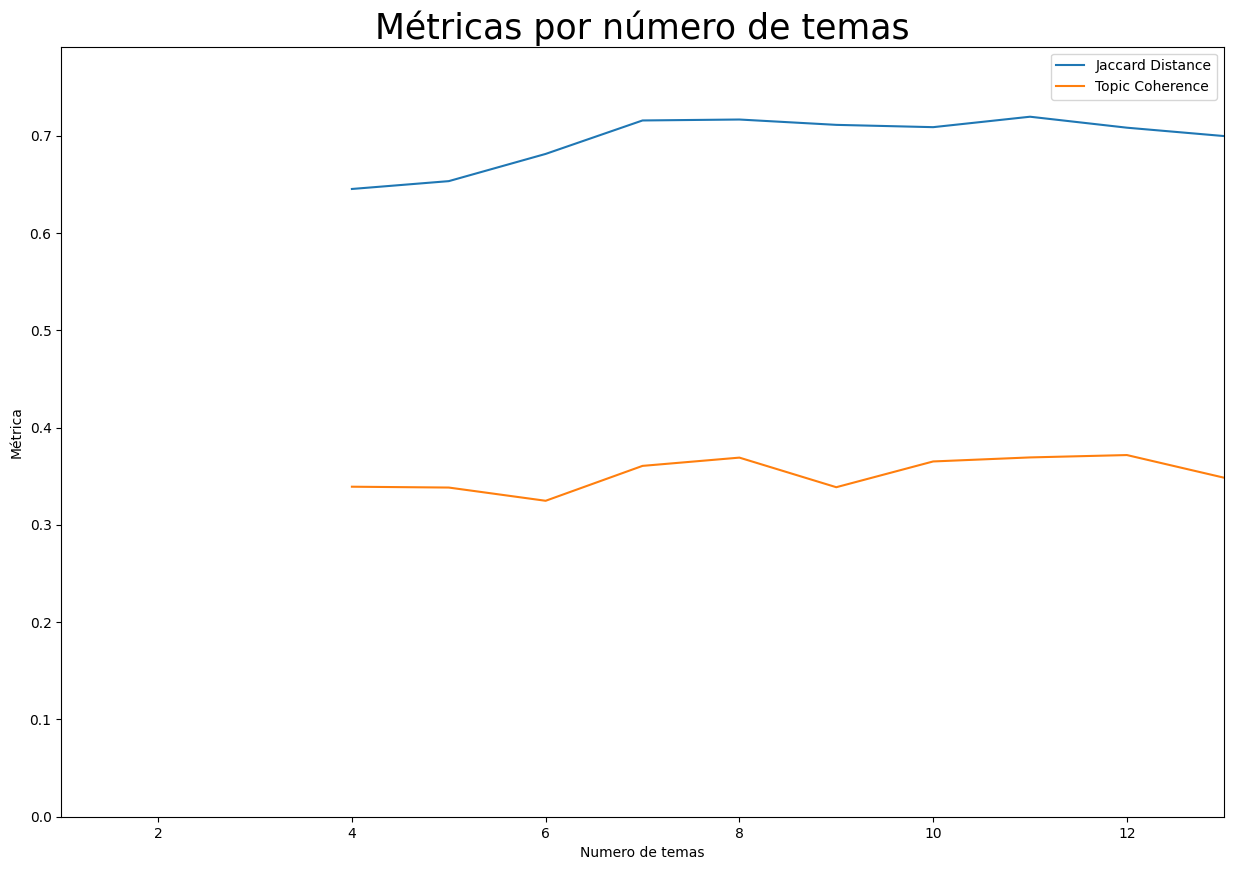

In [33]:
# Plotting metrics across number of topics
plt.figure(figsize=(15,10))

ax = sns.lineplot(x=num_topics[:-1], y=mean_similarities, label='Jaccard Distance')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

y_max = max(max(mean_similarities), max(coherences)) + (0.10 * max(max(mean_similarities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Métricas por número de temas', fontsize=25)
ax.set_ylabel('Métrica')
ax.set_xlabel('Numero de temas')
plt.legend()
plt.show()   

#### 4.2.3. Mejor modelo y predicción de temas
Por lo tanto, el número de temas ideal para el entrenamiento de nuesto modelo para Awareness es 3 y para Streaming es 4:

In [34]:
# Training models with best hiperparameters
#k = ideal_topic_num

# LDA Model for Awareness Day
#lda_model_final = models.LdaMulticore(bow,
#                      num_topics = k,
#                      id2word = id2word,
#                      random_state = 1,
#                      passes=10)

lda_model_final = LDA_models[ideal_topic_num]
print("LDA")
print(lda_model_final.print_topics(-1))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_final, texts=df['review_text'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

LDA
[(0, '0.076*"abortion" + 0.012*"state" + 0.010*"kill" + 0.009*"right" + 0.008*"life" + 0.008*"law" + 0.008*"want" + 0.008*"hell" + 0.007*"ban" + 0.006*"know"'), (1, '0.056*"abortion" + 0.027*"ban" + 0.018*"state" + 0.016*"right" + 0.012*"woman" + 0.007*"get" + 0.006*"roe" + 0.006*"know" + 0.006*"vote" + 0.006*"court"'), (2, '0.069*"abortion" + 0.024*"woman" + 0.016*"right" + 0.015*"ban" + 0.014*"want" + 0.009*"say" + 0.008*"week" + 0.008*"murder" + 0.007*"life" + 0.007*"vote"'), (3, '0.067*"abortion" + 0.015*"make" + 0.011*"get" + 0.009*"woman" + 0.009*"baby" + 0.008*"right" + 0.008*"state" + 0.008*"go" + 0.007*"vote" + 0.007*"support"'), (4, '0.064*"abortion" + 0.018*"woman" + 0.015*"say" + 0.012*"baby" + 0.011*"texas" + 0.010*"subpoena" + 0.009*"paxton" + 0.009*"serve" + 0.008*"right" + 0.008*"ken"'), (5, '0.075*"abortion" + 0.032*"right" + 0.023*"woman" + 0.008*"get" + 0.008*"people" + 0.007*"safe" + 0.007*"one" + 0.007*"know" + 0.007*"like" + 0.007*"court"'), (6, '0.067*"aborti

In [35]:
def get_topic_keywords(ids, lda_model_final, bow):
    for i, row in enumerate(zip(ids, lda_model_final[bow])):
        id_ = row[0]
        row = sorted(row[1], key=lambda x: (x[1]), reverse=True)
        dominant_topic = row[0][0]
        per_contrib = row[0][1]
        #print(dominant_topic, per_contrib)
        wp = lda_model_final.show_topic(dominant_topic)
        topic_keywords = ", ".join([word for word, prop in wp])
        #print(topic_keywords)
        #print('\n')
        yield {'id': id_, 'dominant_topic': dominant_topic, 'perc_contrib': per_contrib, 'topic_keywords': topic_keywords}



In [36]:
lists = get_topic_keywords(df['id'], lda_model_final, bow)
df_dictionary = pd.DataFrame([*lists])
df = df.merge(df_dictionary,on='id')

#### 4.2.4. Visualización de los temas extraídos

In [37]:
import pyLDAvis.gensim_models
# LDA for Awareness Day dataset
vis = pyLDAvis.gensim_models.prepare(lda_model_final, bow, id2word)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/home/olivier/.cache/pypoetry/virtualenvs/miscarriagetwitteranalysis--XHisNvx-py3.8/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [38]:
for num_topic, words in lda_model_final.print_topics():
    print(num_topic, words)

0 0.076*"abortion" + 0.012*"state" + 0.010*"kill" + 0.009*"right" + 0.008*"life" + 0.008*"law" + 0.008*"want" + 0.008*"hell" + 0.007*"ban" + 0.006*"know"
1 0.056*"abortion" + 0.027*"ban" + 0.018*"state" + 0.016*"right" + 0.012*"woman" + 0.007*"get" + 0.006*"roe" + 0.006*"know" + 0.006*"vote" + 0.006*"court"
2 0.069*"abortion" + 0.024*"woman" + 0.016*"right" + 0.015*"ban" + 0.014*"want" + 0.009*"say" + 0.008*"week" + 0.008*"murder" + 0.007*"life" + 0.007*"vote"
3 0.067*"abortion" + 0.015*"make" + 0.011*"get" + 0.009*"woman" + 0.009*"baby" + 0.008*"right" + 0.008*"state" + 0.008*"go" + 0.007*"vote" + 0.007*"support"
4 0.064*"abortion" + 0.018*"woman" + 0.015*"say" + 0.012*"baby" + 0.011*"texas" + 0.010*"subpoena" + 0.009*"paxton" + 0.009*"serve" + 0.008*"right" + 0.008*"ken"
5 0.075*"abortion" + 0.032*"right" + 0.023*"woman" + 0.008*"get" + 0.008*"people" + 0.007*"safe" + 0.007*"one" + 0.007*"know" + 0.007*"like" + 0.007*"court"
6 0.067*"abortion" + 0.012*"ban" + 0.012*"republican" + 0.0

### 4.3. Aparición de síntomas de depresión

In [39]:
# Preparing regex expression with depression words
depression_words = ["overwhelmed", "exhausted", "distressed", "anxiety", "anxious", "tired",
                    "low", "depression", "depressed", "discouraged", "desperate", "demotivated",
                    "insomnia", "cry", "nervous", "worried", "lonely", "sad", "empty"]

depression_words = lemmatize(depression_words)
regex_depr = "|".join(depression_words)

In [40]:
# Filtering tweets with depression words
df['depression'] = df['clean_text'].str.contains(regex_depr, regex=True, flags=re.IGNORECASE)
#df['no_depression'] = df[~df['clean_text'].str.contains(regex_depr, regex=True, flags=re.IGNORECASE)]
print("Avg. Depression polarity ", np.mean(df[df['depression'] == True]['polarity_compound']))
print("Avg. Non depression polarity ", np.mean(df[df['depression'] == False]['polarity_compound']))

Avg. Depression polarity  -0.20143092518560823
Avg. Non depression polarity  -0.1345258085828403


### 4.4. Correlación entre variables

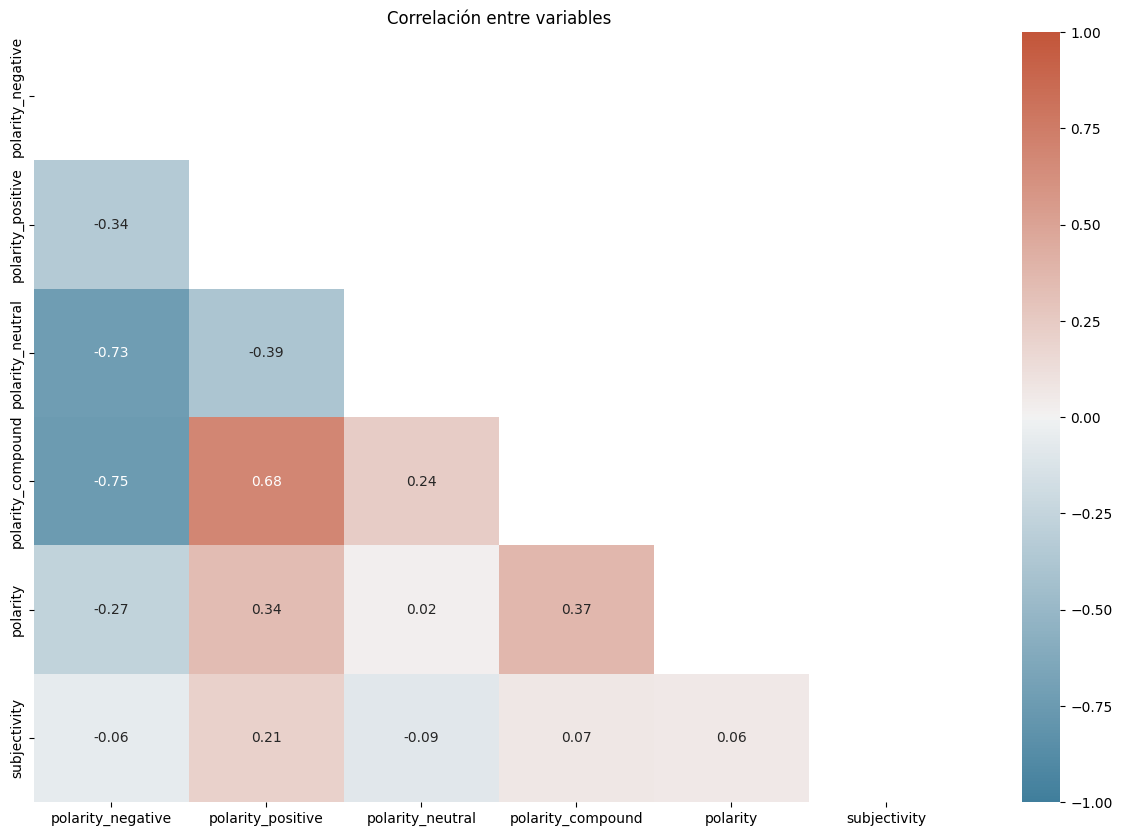

In [41]:
# Correlation heatmap with all numeric fields
#columns_matrix = ['truncated', 'user_verified', 'user_followers_count', 'user_friends_count', 'user_favourites_count',
#'user_statuses_count', 'user_geo_enabled', 'day_of_week', 'hour', 'is_reply', 'has_photos', 'has_videos', 'has_gifs',
#'polarity_negative', 'polarity_positive', 'polarity_neutral', 'polarity_compound', 'subjectivity', 'depression', 'topic']
columns_matrix = df.select_dtypes('float64').columns
corr = df[columns_matrix].corr().round(2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Defining color map
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Plotting correlation matrix
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, annot=True)
plt.title("Correlación entre variables")
plt.show()


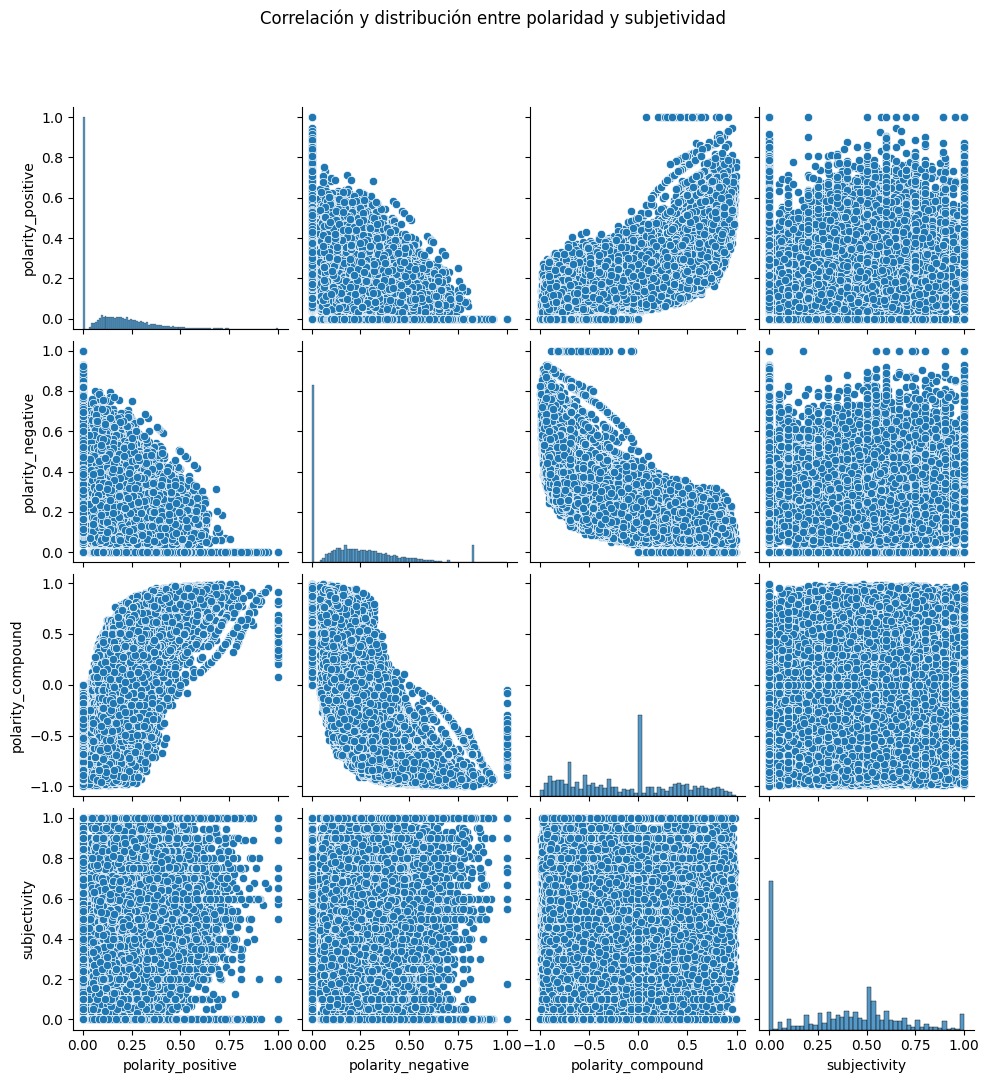

In [42]:
# Correlation between polarity and subjectivity
df_polarity = df[['polarity_positive', 'polarity_negative', 'polarity_compound', 'subjectivity']]
g = sns.pairplot(df_polarity)
g.fig.suptitle("Correlación y distribución entre polaridad y subjetividad", y=1.08)
plt.show()

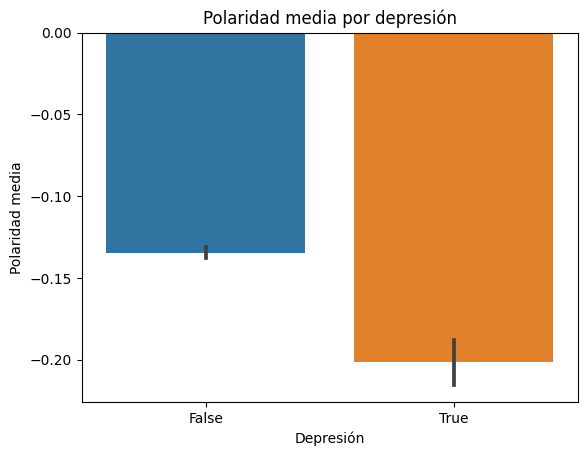

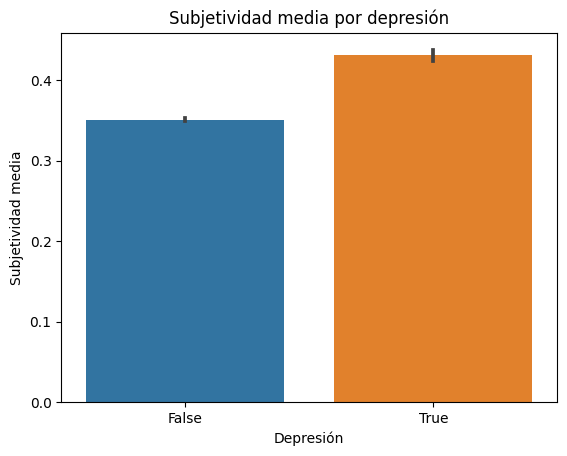

In [43]:
# Correlation between depression and polarity/subjectivity

df_depression = df[['depression', 'polarity_compound', 'subjectivity']]

sns.barplot(x=df_depression['depression'], y=df_depression['polarity_compound'])
plt.title("Polaridad media por depresión")
plt.xlabel("Depresión")
plt.ylabel("Polaridad media")
plt.show()
plt.close()

sns.barplot(x=df_depression['depression'], y=df_depression['subjectivity'])
plt.title("Subjetividad media por depresión")
plt.xlabel("Depresión")
plt.ylabel("Subjetividad media")
plt.show()


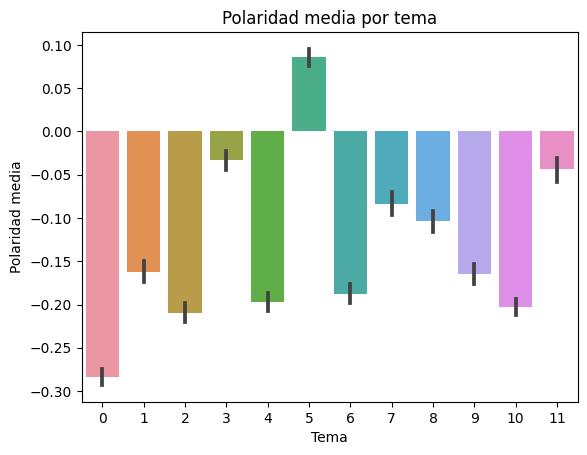

In [44]:
# Correlation between topic and polarity
sns.barplot(x=df['dominant_topic'], y=df['polarity_compound'])
plt.title("Polaridad media por tema")
plt.xlabel("Tema")
plt.ylabel("Polaridad media")
plt.show()

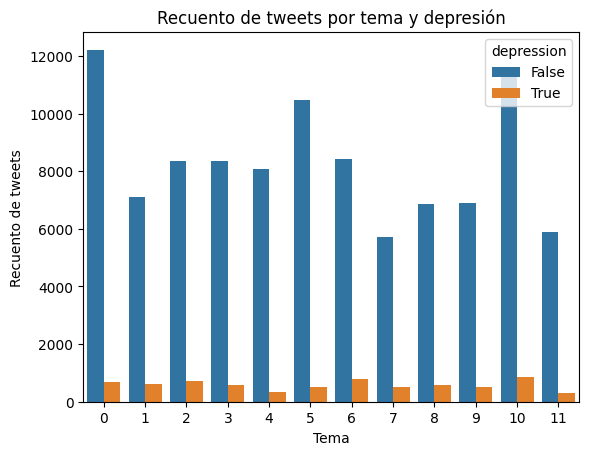

In [45]:
df_topic_depr = df.groupby(['dominant_topic', 'depression']).count().reset_index()
sns.barplot(x=df_topic_depr['dominant_topic'], y=df_topic_depr['polarity_compound'], hue=df_topic_depr['depression'])
plt.title("Recuento de tweets por tema y depresión")
plt.xlabel("Tema")
plt.ylabel("Recuento de tweets")
plt.show()

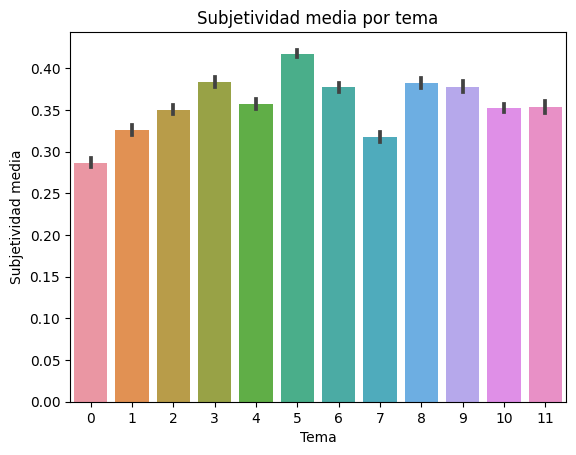

In [46]:
# Correlation between topic and subjectivity
sns.barplot(x=df['dominant_topic'], y=df['subjectivity'])
plt.title("Subjetividad media por tema")
plt.xlabel("Tema")
plt.ylabel("Subjetividad media")
plt.show()

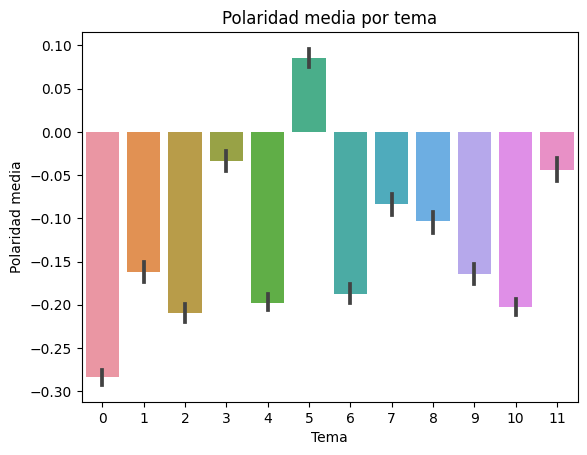

In [47]:
sns.barplot(x=df['dominant_topic'], y=df['polarity_compound'])
plt.title("Polaridad media por tema")
plt.xlabel("Tema")
plt.ylabel("Polaridad media")
plt.show()

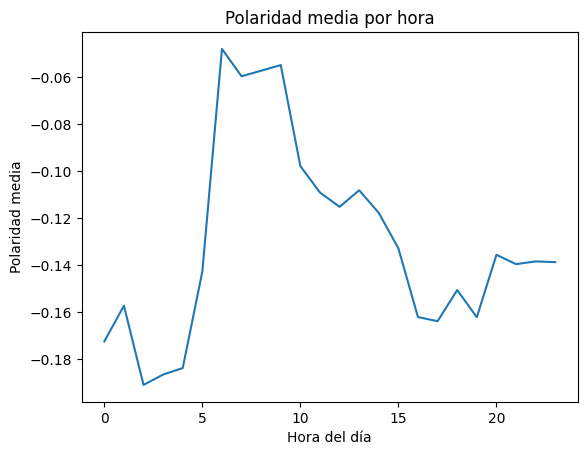

In [49]:
# Temporal polarity and subjectivity
df_aux_aw = df.groupby(df['created_at'].dt.hour)['polarity_compound'].mean()


plt.plot(df_aux_aw)
plt.title("Polaridad media por hora")
plt.xlabel("Hora del día")
plt.ylabel("Polaridad media")
plt.show()


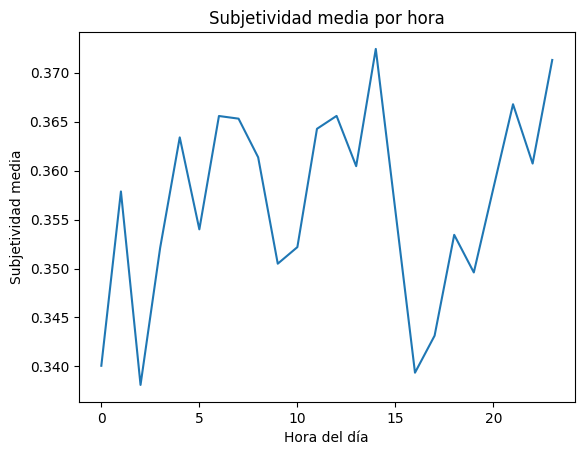

In [50]:
# Temporal polarity and subjectivity
df_aux_aw = df.groupby(df['created_at'].dt.hour)['subjectivity'].mean()



plt.plot(df_aux_aw)
plt.title("Subjetividad media por hora")
plt.xlabel("Hora del día")
plt.ylabel("Subjetividad media")
plt.show()

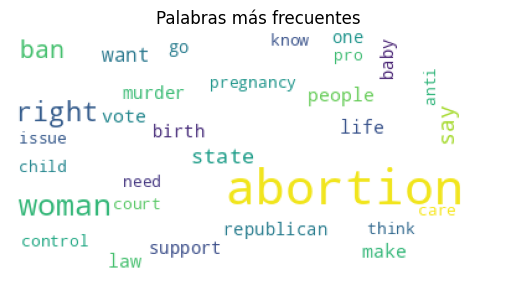

In [52]:
# Word clouds
import warnings
warnings.filterwarnings('ignore')

# 0. Common words in general
# Awareness
words = " ".join(df['clean_text'])
words = str(words)

wordcloud = WordCloud(background_color="white",max_words=30,max_font_size=40, relative_scaling=.5, collocations=False).generate(words)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Palabras más frecuentes")
plt.show()


# We will remove these common words from the following clouds
common_words = r'\b(miscarriage|baby loss|infant loss|pregnancy|pregnant|loss)\b'

Como podemos observar, los word clouds de los datasets nos muestran las palabras más comunes, que son comunes en todos los tweets, como por ejemplo miscarriage, loss o pregnancy. En los siguientes word clouds eliminaremos estas palabras frecuentes para poder observar las diferencias semánticas de los diferentes grupos que hemos comparado.

Text(0.5, 1.0, 'Depression')

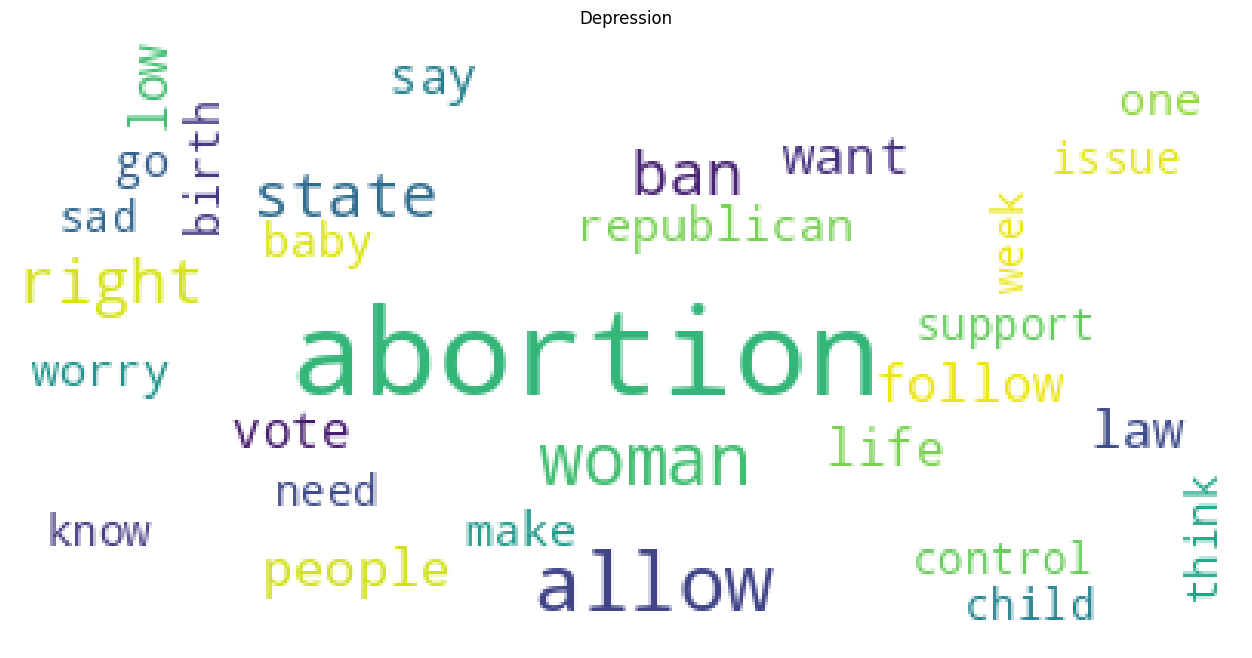

In [53]:
import warnings
warnings.filterwarnings('ignore')

# 1. Depression words vs not depression words

fig, ax = plt.subplots(1, figsize=(20,8))

# Awareness comparison
words_depr = " ".join(df[df['depression'] == True]['clean_text'])
words_depr = str(words_depr)
words_depr = re.sub(common_words, " ", words_depr)

wordcloud = WordCloud(background_color="white",max_words=30,max_font_size=40, relative_scaling=.5, collocations=False).generate(words_depr)
ax.imshow(wordcloud)
ax.axis("off")
ax.set_title("Depression")



Text(0.5, 1.0, 'No depression')

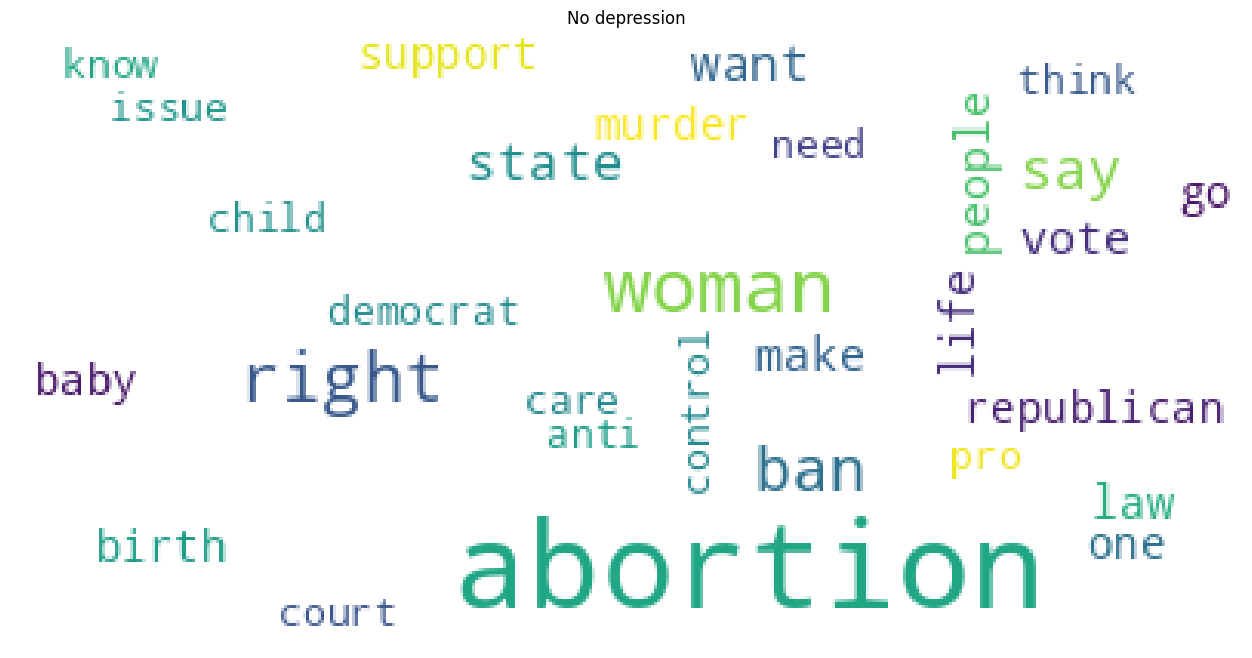

In [55]:
import warnings
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(1, figsize=(20,8))

words_nodepr = " ".join(df[df['depression'] == False]['clean_text'])
words_nodepr = str(words_nodepr)
words_nodepr = re.sub(common_words, " ", words_nodepr)

wordcloud = WordCloud(background_color="white",max_words=30,max_font_size=40, relative_scaling=.5, collocations=False).generate(words_nodepr)
ax.imshow(wordcloud)
ax.axis("off")
ax.set_title("No depression")


In [ ]:
# 2. Awareness topics
df_topic1 = df_awareness[df_awareness['topic'] == 0]
df_topic2 = df_awareness[df_awareness['topic'] == 1]
df_topic3 = df_awareness[df_awareness['topic'] == 2]

fig, ax = plt.subplots(3,1, figsize=(24,14))

# Topic 1
words = " ".join(df_topic1['clean_text'])
words = str(words)
words = re.sub(common_words, " ", words)

wordcloud = WordCloud(background_color="white",max_words=30,max_font_size=40, relative_scaling=.5, collocations=False).generate(words)
ax[0].imshow(wordcloud)
ax[0].axis("off")
ax[0].set_title("Tema 1: awareness")


# Topic 2
words = " ".join(df_topic2['clean_text'])
words = str(words)
words = re.sub(common_words, " ", words)

wordcloud = WordCloud(background_color="white",max_words=30,max_font_size=40, relative_scaling=.5, collocations=False).generate(words)
ax[1].imshow(wordcloud)
ax[1].axis("off")
ax[1].set_title("Tema 2: support")


# Topic 3
words = " ".join(df_topic3['clean_text'])
words = str(words)
words = re.sub(common_words, " ", words)

wordcloud = WordCloud(background_color="white",max_words=30,max_font_size=40, relative_scaling=.5, collocations=False).generate(words)
ax[2].imshow(wordcloud)
ax[2].axis("off")
ax[2].set_title("Tema 3: Oklahoma case")

fig.suptitle("Palabras más frecuentes por tema (Awareness)")
plt.show()

### 4.5. Ejemplos de tweets de cada tema

A continuación mostraremos una selección de tweets de cada tema que hemos identificado en nuestros datos para caracterizar mejor los temas:

In [ ]:
# Awareness tweets
pd.set_option('display.max_colwidth', -1)

# Topic 1: Awareness
print("Topic 1: Awareness tweets ----------------------")
print((df_awareness[df_awareness['id'] == 1449156130094059520].final_text).to_string())
print((df_awareness[df_awareness['id'] == 1449151365582921728].final_text).to_string())
print((df_awareness[df_awareness['id'] == 1449146909386584069].final_text).to_string())

# Topic 2: Support
print("\nTopic 2: Support tweets ----------------------")
print((df_awareness[df_awareness['id'] == 1449007942196473865].final_text).to_string())
print((df_awareness[df_awareness['id'] == 1448261198210818052].final_text).to_string())

# Topic 3: Oklahoma case
print("\nTopic 3: Oklahoma tweets ----------------------")
print((df_awareness[df_awareness['id'] == 1448791454621577217].final_text).to_string())
print((df_awareness[df_awareness['id'] == 1448768844550610944].final_text).to_string())
print((df_awareness[df_awareness['id'] == 1448752437431619588].final_text).to_string())

In [ ]:
# Straming tweets

# Topic 1: Love/Family
print("Topic 1: Love/Family tweets ----------------------")
print((df_streaming[df_streaming['id'] == 1453504151544123395].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1453548826061676547].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1453771475144617987].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1453840403615080452].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1454573664687378433].final_text).to_string())

# Topic 2: Getting Help
print("\nTopic 2: Getting help tweets ----------------------")
print((df_streaming[df_streaming['id'] == 1455351241530232833].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1453851642063990791].final_text).to_string())

# Topic 3 in next chapter

# Topic 4: Death/vaccines
print("\nTopic 4: Death/vaccines tweets ----------------------")
print((df_streaming[df_streaming['id'] == 1454274431916777478].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1454838759149785092].final_text).to_string())

#### 4.5.1. Identificación manual de problemas existentes
En el Tema 3 del dataset Streaming, que habla de las experiencias reales de mujeres que han sufrido un miscarriage, hemos identificado un gran número de tweets que ponen en evidencia diversos problemas graves entorno al aborto espontáneo. Hemos encontrado problemas económicos, problemas de estigma sobre el tema y problemas en el sector sanitario, tanto enfatizando en la salud física como mental:

In [ ]:
# Topic 3: Miscarriage experiences
print("Topic 3: Miscarriage experiencies tweets")

# Economic problems
print("\nEconomic problems ----------------------")
print((df_streaming[df_streaming['id'] == 1454187264188186624].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1454495393643913218].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1454084877507129345].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1454635959023243268].final_text).to_string())

# Stigma problems 
print("\nStigma problems ----------------------")
print((df_streaming[df_streaming['id'] == 1454578368075255809].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1455041490921660417].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1455609810855022599].final_text).to_string())

# Healthcare problems
print("\nHealthcare problems ----------------------")
print((df_streaming[df_streaming['id'] == 1455147608587087875].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1455580227179098115].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1453553962972442626].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1453739381001318400].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1453774695120113665].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1454689448655040513].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1455189476695846925].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1455381870913282061].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1455522245405782023].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1455553691285610508].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1455578258947420162].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1455652323825438724].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1455008932632485896].final_text).to_string())
print((df_streaming[df_streaming['id'] == 1453638597660262405].final_text).to_string())